In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read raw NIFTY options chain data
parent_df = pd.read_csv("DataOptionChains.csv")
parent_df.head()

# Current date = 25 Apr
maturity_days_map = {
    '30Apr': 5,
    '29May': 34,
    '31Jul': 97,
    '25Sep': 153,
    '24Dec': 243
}

# EOD NIFTY spot level on 25 Apr
EOD_NIFTY_SPOT = 24039.35
MIN_STRIKE, MAX_STRIKE = 21000, 27000

# Extract data for each maturity
dfs = []
for i in range(0, parent_df.shape[1], 4):
    sub_df = parent_df.iloc[:, [i, i+3]]
    sub_df.columns = ['IV', 'STRIKE']
    dfs.append(sub_df)

parent_df.head(10)  # Each set of 4 columns points to a different maturity

,IV,BID,ASK,STRIKE,IV.1,BID.1,ASK.1,STRIKE.1,IV.2,BID.2,ASK.2,STRIKE.2,IV.3,BID.3,ASK.3,STRIKE.3,IV.4,BID.4,ASK.4,STRIKE.4
0,-,3132.15,3920.10,20400.0,-,3705.95,3793.70,20350,-,-,-,22500.0,-,-,-,17000.0,-,-,-,13000.0
1,-,3088.90,3949.10,20450.0,-,3640.80,3788.25,20400,-,-,-,22550.0,-,-,-,18000.0,-,-,-,15000.0
2,-,3447.10,3566.50,20500.0,-,3226.00,3802.25,20450,-,-,-,22600.0,-,-,-,19000.0,-,-,-,16000.0
3,-,2992.00,4672.15,20550.0,-,3578.55,3639.75,20500,-,-,-,22650.0,-,-,-,20000.0,-,-,-,16500.0
4,-,2957.25,3706.85,20600.0,-,3135.00,3702.15,20550,-,-,-,22700.0,-,3532.35,3861.2,21000.0,-,7021,8310,17000.0
5,-,3310.15,3429.95,20650.0,-,3318.45,3597.25,20600,-,-,-,22750.0,-,2682.35,2730,22000.0,-,-,6800,18000.0
6,-,2870.20,3600.10,20700.0,-,3047.60,3598.15,20650,-,-,-,22800.0,-,1889.15,1939.95,23000.0,-,-,6000,19000.0
7,-,3202.60,3668.70,20750.0,-,3029.10,3493.30,20700,-,-,-,22850.0,9.39,1220,1235.55,24000.0,-,-,-,19500.0
8,-,2782.95,3569.05,20800.0,-,2959.40,3502.35,20750,-,-,-,22900.0,10.54,675.1,688.1,25000.0,-,4708.9,4768.45,20000.0
9,-,2740.05,3514.35,20850.0,20.87,2986.70,3359.95,20800,-,-,-,22950.0,10.89,321,330,26000.0,-,3871.25,3921.95,21000.0


In [3]:
# Clean the data: remove missing IV or STRIKE entries
for i in range(len(dfs)):
    dfs[i] = dfs[i].replace('-', np.nan)
    dfs[i] = dfs[i][dfs[i]['IV'].notna() & dfs[i]['STRIKE'].notna()]
    dfs[i] = dfs[i].reset_index(drop=True)

# Merge all maturities into one dataframe
merged_df = pd.DataFrame(columns=['MATURITY', 'STRIKE', 'IV'])
maturities = list(maturity_days_map.values())
for i in range(len(dfs)):
    dfs[i]['MATURITY'] = maturities[i]
    merged_df = pd.concat([merged_df, dfs[i][['MATURITY', 'STRIKE', 'IV']]], ignore_index=True)

# Trim extreme strikes and ensure numeric types
merged_df = merged_df[(merged_df['STRIKE'] >= MIN_STRIKE) & (merged_df['STRIKE'] <= MAX_STRIKE)]
merged_df[['STRIKE', 'MATURITY', 'IV']] = merged_df[['STRIKE', 'MATURITY', 'IV']].apply(pd.to_numeric, errors='coerce')

merged_df.head(5)

,MATURITY,STRIKE,IV
0,5,21500.0,48.50
1,5,22050.0,86.00
2,5,22100.0,76.83
3,5,22300.0,55.84
4,5,22450.0,34.46


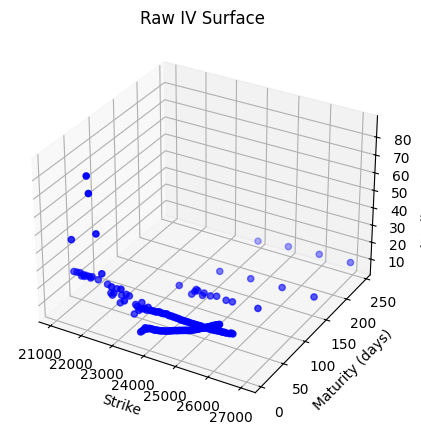

In [4]:
# 3D scatter plot of raw IV surface
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(merged_df['STRIKE'], merged_df['MATURITY'], merged_df['IV'], c='b', marker='o')

ax.set_xlabel('Strike')
ax.set_ylabel('Maturity (days)')
ax.set_zlabel('Implied Volatility')
ax.set_title('Raw IV Surface')

plt.show()

In [5]:
# Empty dictionaries to store fitted coefficients
maturity_fits = {}   # key = maturity (days), value = [a, b, c]
strike_fits = {}     # key = strike, value = [A, B, C]

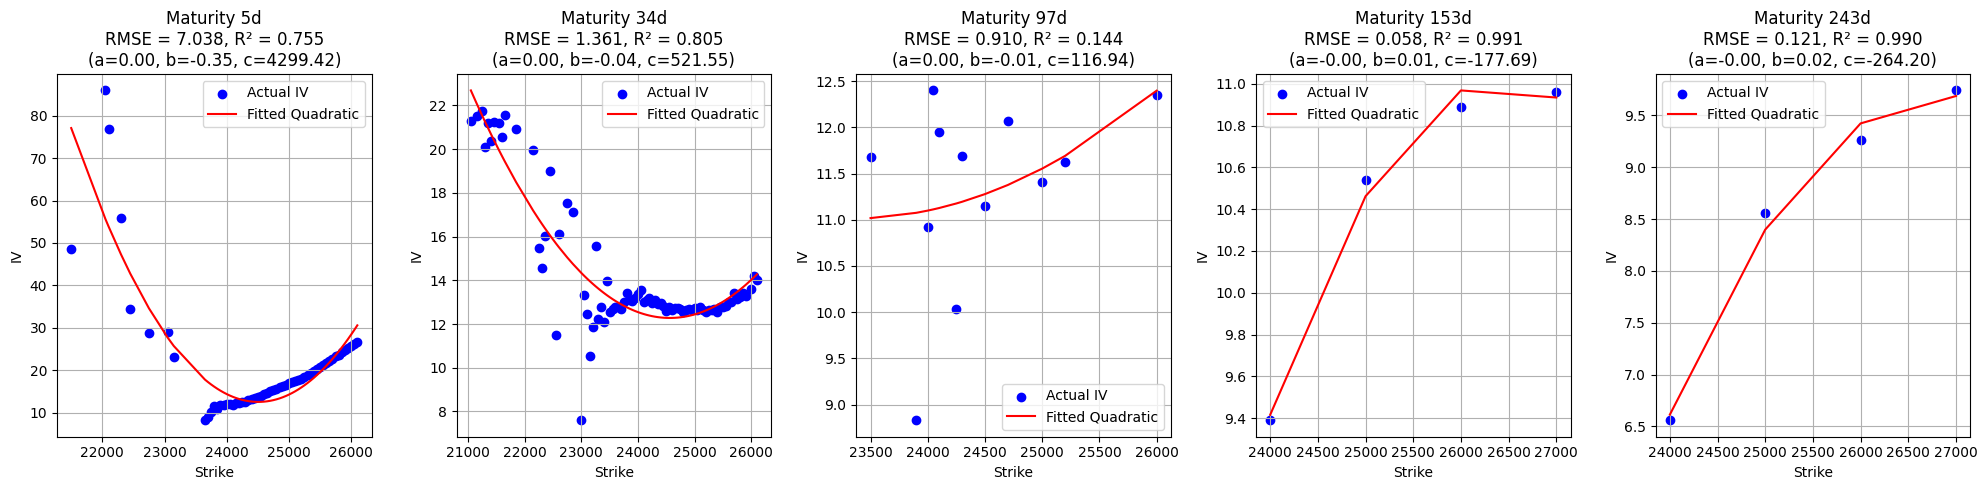

In [6]:
# Fit quadratic curve to IV vs Strike for each maturity
def fit_quadratic_strike_iv(K, IV):
    X = np.column_stack((K**2, K, np.ones_like(K)))
    theta = np.linalg.inv(X.T @ X) @ (X.T @ IV)
    return theta  # returns [a, b, c]

def fit_and_plot_quadratic(merged_df):
    maturities = list(maturity_days_map.values())
    fig, axes = plt.subplots(1, len(maturities), figsize=(20, 5))
    for idx, maturity in enumerate(maturities):
        df_maturity = merged_df[merged_df['MATURITY'] == maturity]
        assert not df_maturity.empty
        K = df_maturity['STRIKE'].values
        IV = df_maturity['IV'].values
        a, b, c = fit_quadratic_strike_iv(K, IV)
        maturity_fits[maturity] = [a, b, c]
        IV_pred = a * K**2 + b * K + c
        # RMSE and R-squared
        rmse = np.sqrt(np.mean((IV - IV_pred)**2))
        SSE = np.sum((IV - IV_pred)**2)
        SST = np.sum((IV - np.mean(IV))**2)
        r2 = 1 - (SSE / SST)
        # Plot
        ax = axes[idx]
        ax.scatter(K, IV, label='Actual IV', color='blue')
        ax.plot(np.sort(K), a*np.sort(K)**2 + b*np.sort(K) + c, label='Fitted Quadratic', color='red')
        ax.set_title(f'Maturity {maturity}d\nRMSE = {rmse:.3f}, R² = {r2:.3f}\n(a={a:.2f}, b={b:.2f}, c={c:.2f})')
        ax.set_xlabel('Strike')
        ax.set_ylabel('IV')
        ax.legend()
        ax.grid(True)
    plt.tight_layout()
    plt.show()

fit_and_plot_quadratic(merged_df)

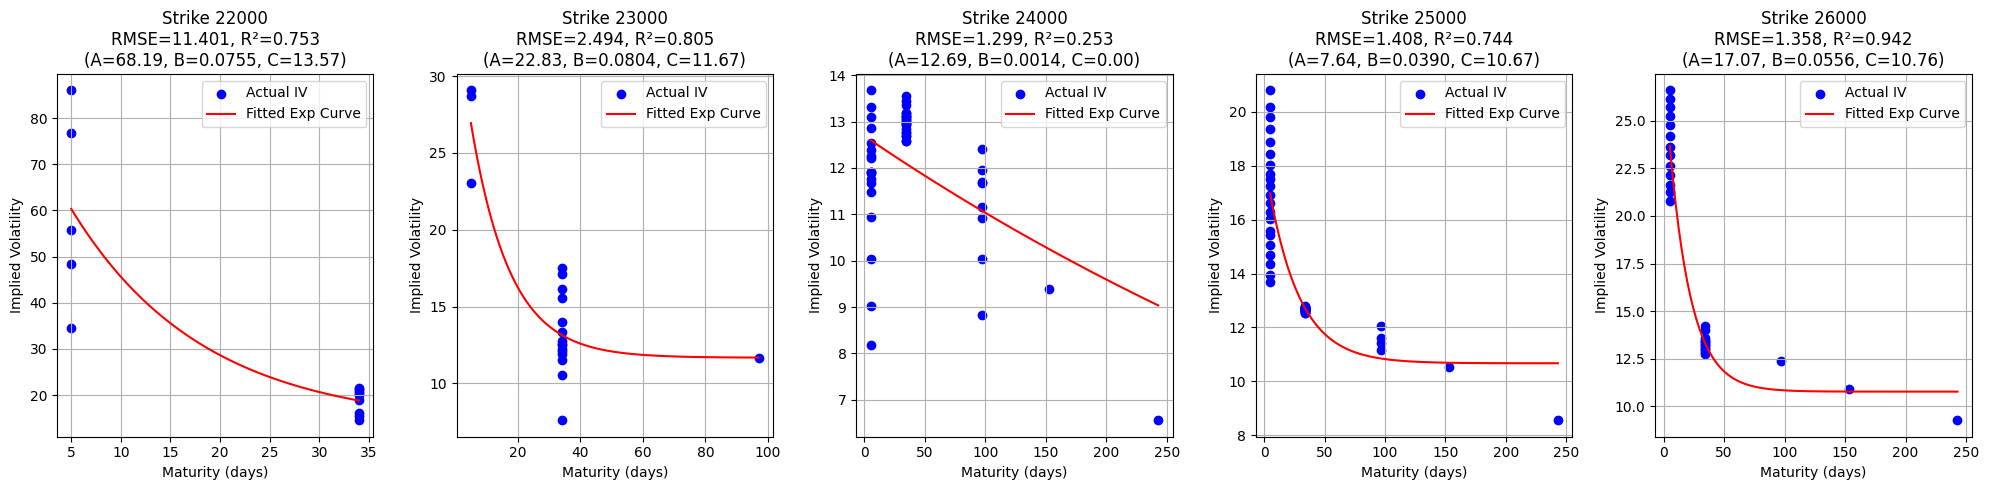

In [7]:
# Fit exponential decay curve to IV vs Maturity for selected strikes

def pick_strikes(merged_df, num_strikes=5):
    strikes_available = np.sort(merged_df['STRIKE'].unique())
    MIN_STRIKE, MAX_STRIKE = 22000, 26000
    return np.linspace(MIN_STRIKE, MAX_STRIKE, num_strikes)

def exponential_decay(T, A, B, C):
    return A * np.exp(-B * T) + C

def fit_iv_maturity(T_values, IV_values):
    A_init = max(IV_values) - min(IV_values)
    B_init = 0.01
    C_init = min(IV_values)
    initial_guess = [A_init, B_init, C_init]
    bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])
    popt, _ = curve_fit(exponential_decay, T_values, IV_values, p0=initial_guess, bounds=bounds, maxfev=10000)
    return popt  # [A, B, C]

def fit_and_plot_maturity_curves(merged_df, target_strikes):
    fig, axes = plt.subplots(1, len(target_strikes), figsize=(20, 5))
    for idx, strike in enumerate(target_strikes):
        df_strike = merged_df[np.isclose(merged_df['STRIKE'], strike, atol=500)]
        if df_strike.empty:
            raise Exception(f"No data points found for strike {strike}")
        
        T = df_strike['MATURITY'].values
        IV = df_strike['IV'].values

        A, B, C = fit_iv_maturity(T, IV)
        strike_fits[strike] = [A, B, C]
        IV_pred = exponential_decay(T, A, B, C)

        # RMSE and R²
        rmse = np.sqrt(np.mean((IV - IV_pred)**2))
        sse = np.sum((IV - IV_pred)**2)
        sst = np.sum((IV - np.mean(IV))**2)
        r2 = 1 - sse/sst

        # Plot
        ax = axes[idx]
        ax.scatter(T, IV, label='Actual IV', color='blue')
        T_smooth = np.linspace(T.min(), T.max(), 100)
        ax.plot(T_smooth, exponential_decay(T_smooth, A, B, C), label='Fitted Exp Curve', color='red')
        ax.set_title(f"Strike {strike:.0f}\nRMSE={rmse:.3f}, R²={r2:.3f}\n(A={A:.2f}, B={B:.4f}, C={C:.2f})")
        ax.set_xlabel('Maturity (days)')
        ax.set_ylabel('Implied Volatility')
        ax.legend()
        ax.grid(True)
    plt.tight_layout()
    plt.show()

target_strikes = pick_strikes(merged_df)
fit_and_plot_maturity_curves(merged_df, target_strikes)

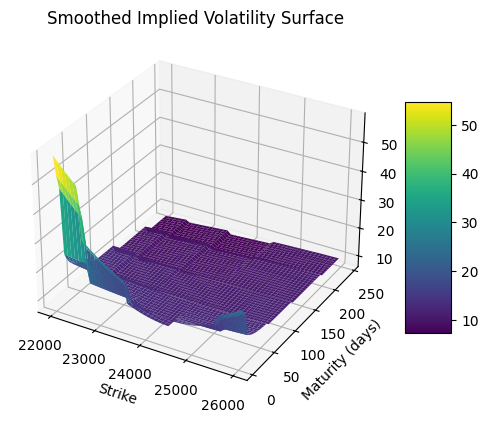

In [8]:
# Combine individual fits into a smoothed 3D implied volatility surface

GRID_POINTS = 50
T_MIN, T_MAX = 5, 243
K_MIN, K_MAX = 22000, 26000
strike_grid = np.linspace(K_MIN, K_MAX, GRID_POINTS)
maturity_grid = np.linspace(T_MIN, T_MAX, GRID_POINTS)

IV_grid = np.zeros((len(maturity_grid), len(strike_grid)))

# Predict IV at each (strike, maturity) point
for i, T in enumerate(maturity_grid):
    for j, K in enumerate(strike_grid):
        nearest_maturity = min(maturity_fits.keys(), key=lambda x: abs(x - T))
        a, b, c = maturity_fits[nearest_maturity]
        IV_strike = a * K**2 + b * K + c
        
        nearest_strike = min(strike_fits.keys(), key=lambda x: abs(x - K))
        A, B, C = strike_fits[nearest_strike]
        IV_maturity = A * np.exp(-B * T) + C
        
        # Simple average of strike and maturity predictions
        IV_grid[i, j] = 0.5 * IV_strike + 0.5 * IV_maturity

# Plot the smoothed 3D surface
Strike_mesh, Maturity_mesh = np.meshgrid(strike_grid, maturity_grid)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Strike_mesh, Maturity_mesh, IV_grid, cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

ax.set_xlabel('Strike')
ax.set_ylabel('Maturity (days)')
ax.set_zlabel('Implied Volatility')
ax.set_title('Smoothed Implied Volatility Surface')
plt.show()


Root Mean Squared Error (RMSE): 3.5452
Standard Deviation of Actual IVs: 9.6308
RMSE / Std Dev Ratio: 0.3681



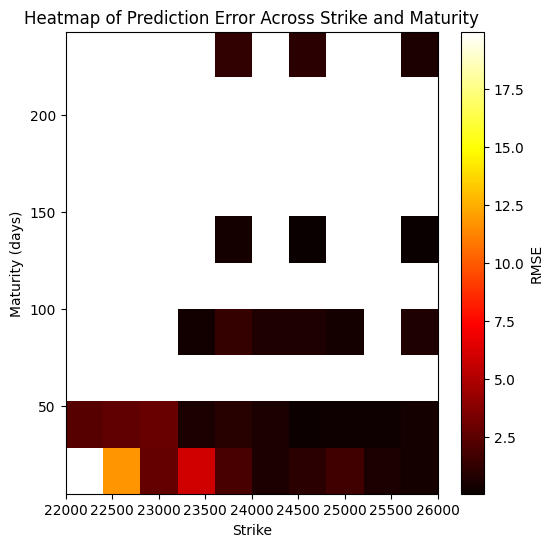

In [9]:
# Evaluate surface fit and visualize error distribution

def predict_iv_surface(K, T, strike_grid, maturity_grid, IV_grid):
    strike_idx = np.abs(strike_grid - K).argmin()
    maturity_idx = np.abs(maturity_grid - T).argmin()
    return IV_grid[maturity_idx, strike_idx]

# Predict IVs and calculate errors
actual_IVs = []
predicted_IVs = []

for idx, row in merged_df.iterrows():
    K = row['STRIKE']
    T = row['MATURITY']
    IV_actual = row['IV']
    IV_pred = predict_iv_surface(K, T, strike_grid, maturity_grid, IV_grid)
    actual_IVs.append(IV_actual)
    predicted_IVs.append(IV_pred)

actual_IVs = np.array(actual_IVs)
predicted_IVs = np.array(predicted_IVs)
errors = (actual_IVs - predicted_IVs)**2

# Metrics
mse = np.mean(errors)
rmse = np.sqrt(mse)
std_dev_actual = np.std(actual_IVs)
error_ratio = rmse / std_dev_actual

print(f"\nRoot Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Standard Deviation of Actual IVs: {std_dev_actual:.4f}")
print(f"RMSE / Std Dev Ratio: {error_ratio:.4f}\n")

# Create heatmap of regional errors
merged_df['ERROR'] = errors

strike_bins = np.linspace(K_MIN, K_MAX, 10)
maturity_bins = np.linspace(T_MIN, T_MAX, 10)

merged_df['STRIKE_BIN'] = np.digitize(merged_df['STRIKE'], strike_bins)
merged_df['MATURITY_BIN'] = np.digitize(merged_df['MATURITY'], maturity_bins)

error_grid = np.zeros((len(maturity_bins), len(strike_bins)))

for i in range(1, len(maturity_bins)+1):
    for j in range(1, len(strike_bins)+1):
        region_errors = merged_df[(merged_df['MATURITY_BIN'] == i) & (merged_df['STRIKE_BIN'] == j)]['ERROR']
        if not region_errors.empty:
            error_grid[i-1, j-1] = np.sqrt(region_errors.mean())
        else:
            error_grid[i-1, j-1] = np.nan

# Plot heatmap
plt.figure(figsize=(6,6))
plt.imshow(error_grid, cmap='hot', origin='lower', extent=[22000, 26000, 5, 243], aspect='auto')
plt.colorbar(label='RMSE')
plt.xlabel('Strike')
plt.ylabel('Maturity (days)')
plt.title('Heatmap of Prediction Error Across Strike and Maturity')
plt.show()